In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from typing import Optional, List
import matplotlib.pyplot as plt

各トークンの周辺ウィンドウの K/V をまとめて取り出す関数を示します。

In [2]:
# -----------------------------
# ユーティリティ: 1D unfold (K/V のウィンドウ抽出)
# -----------------------------
def unfold_kv(x: torch.Tensor, kernel_size: int, padding: int = 0):
    """
    x: (B, H, T, D)
    returns: (B, H, T, window_len, D)
    kernel_size: window length (2*window + 1)
    padding: left/right padding for edges (usually window)
    """
    B, H, T, D = x.shape
    # reshape to image-like: (B*H, D, 1, T)
    x_img = x.permute(0, 1, 3, 2).reshape(B * H, D, 1, T)
    # use unfold on width dimension (kernel_size)
    # unfold returns (B*H, D * kernel_size, L_out) where L_out = T if stride=1 and padding applied
    x_unf = F.unfold(x_img, kernel_size=(1, kernel_size), padding=(0, padding), stride=(1, 1))
    # reshape to (B*H, D, kernel_size, T)
    x_unf = x_unf.view(B * H, D, kernel_size, T)
    # permute to (B, H, T, kernel_size, D)
    x_unf = x_unf.permute(0, 3, 2, 1).reshape(B, H, T, kernel_size, D)
    return x_unf


In [3]:
B = 2
T = 64
dim = 256
num_heads = 2
window = 8
head_dim = dim // num_heads
device = "cuda" if torch.cuda.is_available() else "cpu"

# random data
x = torch.randn(B, T, dim, device=device)

# mark a few global tokens per batch
global_mask = torch.zeros(B, T, dtype=torch.bool, device=device)


In [4]:
# choose 3 global tokens per batch
import random
random.seed(0)
for b in range(B):
    choices = random.sample(range(T), 3)
    global_mask[b, choices] = True

In [5]:
# ネットワークパラメータ定義
q_proj = nn.Linear(dim, dim, bias=False)
k_proj = nn.Linear(dim, dim, bias=False)
v_proj = nn.Linear(dim, dim, bias=False)

out_proj = nn.Linear(dim, dim, bias=False)

In [7]:
B, T, D = x.shape
kernel_size = 2 * window + 1

# 1) Project and shape into multi-head: (B, H, T, head_dim)
q = q_proj(x).view(B, T, num_heads, head_dim).permute(0, 2, 1, 3)
k = k_proj(x).view(B, T, num_heads, head_dim).permute(0, 2, 1, 3)
v = v_proj(x).view(B, T, num_heads, head_dim).permute(0, 2, 1, 3)

In [8]:
# 2) Extract local windows for K and V via unfold (vectorized)
# pad = window to allow edges to have full kernel_size with padding positions
K_windows = unfold_kv(k, kernel_size=kernel_size, padding=window)  # (B,H,T,win,Dh)
V_windows = unfold_kv(v, kernel_size=kernel_size, padding=window)  # (B,H,T,win,Dh)

unfold_kv(k, kernel_size=kernel_size, padding=window)の出力は以下の通り。




| 次元             | 意味                        |
| -------------- | ------------------------- |
| **B**          | バッチ数                      |
| **H**          | アテンションのヘッド数               |
| **T**          | トークン位置（時系列長）              |
| **window_len** | 各トークンが見る K/V の局所ウィンドウのサイズ |
| **D**          | Key/Value のヘッド次元          |

In [9]:
q.shape

torch.Size([2, 2, 64, 128])

In [ ]:
K_windows.shape

torch.Size([2, 2, 64, 17, 128])

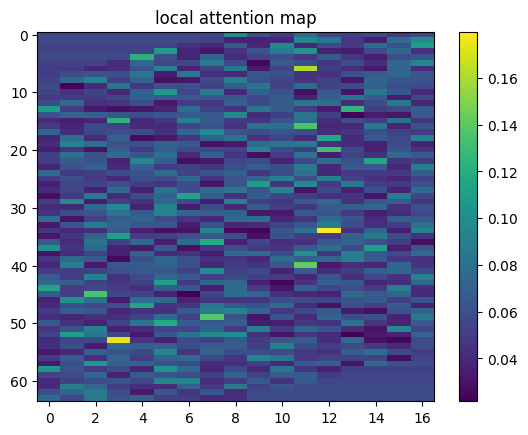

In [13]:
# 3) Local scores: Q (B,H,T,dh) @ K_windows.transpose(-2,-1) -> (B,H,T,win)
# Use einsum for clarity and speed
# scores_local shape: (B, H, T, win)
scores_local = torch.einsum("bhtd,bhtwd->bhtw", q, K_windows) / (head_dim ** 0.5)
attn_weights = F.softmax(scores_local, dim=-1)  # shape (B,H,T,win)

import matplotlib.pyplot as plt

# ローカルアテンションマップを可視化
plt.imshow(attn_weights[0, 0].detach().cpu().numpy(), aspect='auto')
plt.colorbar()
plt.title("local attention map")
plt.show()


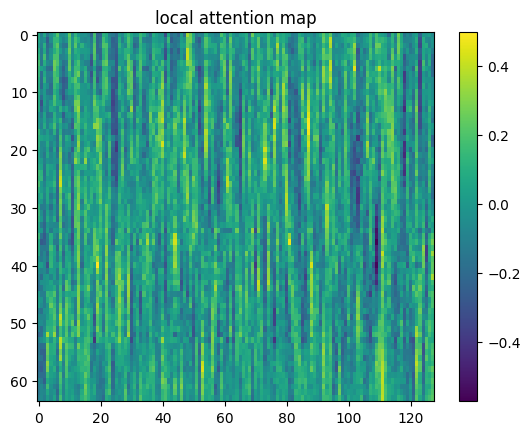

In [15]:
scores_global = None
V_global = None
K_global = None

# Weighted sum over V_windows
context_local = torch.einsum("bhtw,bhtwd->bhtd", attn_weights, V_windows)  # (B,H,T,dh)
out = context_local

# ローカルな分散表現
plt.imshow(out[0, 0].detach().cpu().numpy(), aspect='auto')
plt.colorbar()
plt.title("context_local map")
plt.show()

In [ ]:
# -----------------------------
# Hybrid Sparse Attention (Local + Global)
# -----------------------------
class HybridSparseAttention(nn.Module):
    def __init__(self, dim: int, num_heads: int = 8, window: int = 4, dropout: float = 0.0):
        """
        dim: model embed dim
        num_heads: # heads
        window: half-window size (each token attends to 2*window+1 neighbors centered)
        """
        super().__init__()
        assert dim % num_heads == 0
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.window = window
        self.kernel_size = 2 * window + 1
        self.q_proj = nn.Linear(dim, dim, bias=False)
        self.k_proj = nn.Linear(dim, dim, bias=False)
        self.v_proj = nn.Linear(dim, dim, bias=False)
        self.out_proj = nn.Linear(dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        x: torch.Tensor,                    # (B, T, D)
        global_mask: Optional[torch.Tensor] # (B, T) bool: True -> this position is global token
    ):
        B, T, D = x.shape
        device = x.device

        # 1) Project and shape into multi-head: (B, H, T, head_dim)
        q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.k_proj(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.v_proj(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        # q,k,v: (B, H, T, D_head)

        # 2) Extract local windows for K and V via unfold (vectorized)
        # pad = window to allow edges to have full kernel_size with padding positions
        K_windows = unfold_kv(k, kernel_size=self.kernel_size, padding=self.window)  # (B,H,T,win,Dh)
        V_windows = unfold_kv(v, kernel_size=self.kernel_size, padding=self.window)  # (B,H,T,win,Dh)

        # 3) Local scores: Q (B,H,T,dh) @ K_windows.transpose(-2,-1) -> (B,H,T,win)
        # Use einsum for clarity and speed
        # scores_local shape: (B, H, T, win)
        scores_local = torch.einsum("bhtd,bhtwd->bhtw", q, K_windows) / (self.head_dim ** 0.5)

        # 4) Global part: gather global keys/values
        if global_mask is None:
            # no global, just compute local attentions
            scores_global = None
            V_global = None
            K_global = None
        else:
            # indices of global per batch may vary, so gather per batch
            # build K_global: (B, H, G, Dh)
            # build V_global: (B, H, G, Dh)
            global_idx_list: List[torch.Tensor] = []
            maxG = 0
            for b in range(B):
                idx = torch.nonzero(global_mask[b].to(device), as_tuple=False).squeeze(-1)
                global_idx_list.append(idx)
                if idx.numel() > maxG:
                    maxG = idx.numel()
            if maxG == 0:
                scores_global = None
                K_global = None
                V_global = None
            else:
                # We'll pad global lists to same length maxG with zeros and use a mask
                K_global = torch.zeros(B, self.num_heads, maxG, self.head_dim, device=device)
                V_global = torch.zeros(B, self.num_heads, maxG, self.head_dim, device=device)
                global_token_mask = torch.zeros(B, maxG, dtype=torch.bool, device=device)
                for b in range(B):
                    idx = global_idx_list[b]
                    if idx.numel() == 0:
                        continue
                    kg = k[b, :, idx, :]  # (H, G_b, Dh)
                    vg = v[b, :, idx, :]
                    G_b = kg.shape[1]
                    K_global[b, :, :G_b, :] = kg
                    V_global[b, :, :G_b, :] = vg
                    global_token_mask[b, :G_b] = True  # valid positions

                # Now compute scores_global: Q (B,H,T,dh) @ K_global.transpose(-2,-1) -> (B,H,T,G)
                # Note: broadcasting across G (maxG)
                # We'll produce scores_global with padded positions (where global_token_mask=False), their scores will be -inf later
                scores_global = torch.einsum("bhtd,bhgd->bhtg", q, K_global) / (self.head_dim ** 0.5)
                # mask out padded global slots later

        # 5) Combine local and global scores: concat along last dim and softmax
        if scores_global is None:
            # only local
            attn_weights = F.softmax(scores_local, dim=-1)  # shape (B,H,T,win)
            # Weighted sum over V_windows
            context_local = torch.einsum("bhtw,bhtwd->bhtd", attn_weights, V_windows)  # (B,H,T,dh)
            out = context_local
        else:
            # mask invalid global slots by large negative
            # scores_global: (B,H,T,G)
            # create mask for G: (B, G)
            gmask = global_token_mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,G)
            # set invalid global positions to -1e9
            scores_global = scores_global.masked_fill(~gmask, float("-1e9"))

            # concat local + global -> (B,H,T, win + G)
            scores_cat = torch.cat([scores_local, scores_global], dim=-1)  # (B,H,T, Ktot)

            attn_weights_cat = F.softmax(scores_cat, dim=-1)  # (B,H,T,Ktot)
            attn_weights_cat = self.dropout(attn_weights_cat)

            # split weights
            w_local = attn_weights_cat[..., : self.kernel_size]  # (B,H,T,win)
            w_global = attn_weights_cat[..., self.kernel_size :]  # (B,H,T,G)

            # compute contexts
            ctx_local = torch.einsum("bhtw,bhtwd->bhtd", w_local, V_windows)  # (B,H,T,dh)
            ctx_global = torch.einsum("bhtg,bhgd->bhtd", w_global, V_global)  # (B,H,T,dh)

            out = ctx_local + ctx_global

        # 6) merge heads & project out
        out = out.permute(0, 2, 1, 3).contiguous().view(B, T, D)
        out = self.out_proj(out)  # (B,T,D)

        # Also optionally return a full-attention-like map for visualization:
        # Build full_attn: (B, T, T) with zeros outside local windows and global slots indicated
        # For memory reasons we build per-batch if requested (here we always build for simplicity)
        full_attn = torch.zeros(B, self.num_heads, T, T, device=device)
        # fill local parts
        # we'll vectorize: for each offset in kernel_size, compute contribution positions
        offsets = torch.arange(-self.window, self.window + 1, device=device)
        # positions matrix: (T, kernel_size) -> indices in [0,T)
        pos_idx = (torch.arange(T, device=device).unsqueeze(1) + offsets.unsqueeze(0)).clamp(0, T - 1)
        # w_local shape (B,H,T,win) -> assign into full_attn[..., pos_idx]
        # We can scatter
        for i in range(self.kernel_size):
            idx = pos_idx[:, i]  # (T,)
            full_attn[..., :, idx] += 0  # no-op to ensure size; below we fill per-batch
        # We'll fill per-batch-head with loop over batch/head (small overhead for visualization)
        for b in range(B):
            for h in range(self.num_heads):
                # local
                for t in range(T):
                    left = max(0, t - self.window)
                    right = min(T, t + self.window + 1)
                    win_len = right - left
                    if scores_global is None:
                        wloc = F.softmax(scores_local[b, h, t, :win_len], dim=-1)
                        full_attn[b, h, t, left:right] = wloc
                    else:
                        # recompute combined weights for this (b,h,t) to be consistent
                        # slice
                        s_local = scores_local[b, h, t, :win_len]
                        s_glob = scores_global[b, h, t, : scores_global.shape[-1]]
                        s_cat = torch.cat([s_local, s_glob], dim=-1)
                        wcat = F.softmax(s_cat, dim=-1)
                        wloc = wcat[:win_len]
                        wglob = wcat[win_len:]
                        full_attn[b, h, t, left:right] = wloc
                        if global_token_mask[b].any():
                            # distribute global weights to actual positions
                            glob_idx = global_idx_list[b]  # indices tensor
                            # if padded, wglob length = maxG; but only first len(glob_idx) are valid
                            G_b = glob_idx.numel()
                            if G_b > 0:
                                full_attn[b, h, t, glob_idx] += wglob[:G_b]

        return out, full_attn  # out: (B,T,D), full_attn: (B,H,T,T)


In [ ]:
# -----------------------------
# ベンチマーク＆簡単な精度チェック
# -----------------------------
def benchmark_and_check():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    B = 2
    T = 64
    D = 256
    H = 2
    window = 8
    # random data
    x = torch.randn(B, T, D, device=device)

    # mark a few global tokens per batch
    global_mask = torch.zeros(B, T, dtype=torch.bool, device=device)
    # choose 3 global tokens per batch
    import random
    random.seed(0)
    for b in range(B):
        choices = random.sample(range(T), 3)
        global_mask[b, choices] = True

    # modules
    hybrid = HybridSparseAttention(dim=D, num_heads=H, window=window).to(device)
    # baseline full multihead attention via simple implementation
    class FullMHA(nn.Module):
        def __init__(self, D, H):
            super().__init__()
            self.D = D
            self.H = H
            self.head = HybridSparseAttention(D, H, window=window)  # reuse projections
        def forward(self, x):
            # naive: compute full attention by using same projections
            B,T,D = x.shape
            q = self.head.q_proj(x).view(B, T, self.head.num_heads, self.head.head_dim).permute(0,2,1,3)
            k = self.head.k_proj(x).view(B, T, self.head.num_heads, self.head.head_dim).permute(0,2,1,3)
            v = self.head.v_proj(x).view(B, T, self.head.num_heads, self.head.head_dim).permute(0,2,1,3)
            scores = torch.einsum("bhqd,bhkd->bhqk", q, k) / (self.head.head_dim ** 0.5)
            attn = F.softmax(scores, dim=-1)
            ctx = torch.einsum("bhqk,bhkd->bhqd", attn, v)
            out = ctx.permute(0,2,1,3).reshape(B,T,D)
            out = self.head.out_proj(out)
            return out, attn

    fullmha = FullMHA(D, H).to(device)

    # warmup
    for _ in range(3):
        _ = hybrid(x, global_mask)
        _ = fullmha(x)

    # time hybrid
    torch.cuda.synchronize() if device=="cuda" else None
    t0 = time.time()
    out_h, attn_h = hybrid(x, global_mask)
    torch.cuda.synchronize() if device=="cuda" else None
    t1 = time.time()

    t_hybrid = t1 - t0

    # time full
    torch.cuda.synchronize() if device=="cuda" else None
    t0 = time.time()
    out_f, attn_f = fullmha(x)
    torch.cuda.synchronize() if device=="cuda" else None
    t1 = time.time()
    t_full = t1 - t0

    print(f"Time hybrid: {t_hybrid:.4f}s  | Time full: {t_full:.4f}s  | speedup: {t_full / max(t_hybrid,1e-12):.2f}x")
    # basic relative difference check (not exact since hybrid is sparse)
    print("Output norm diff (L2):", torch.norm(out_h - out_f).item())
    print("hybrid out shape:", out_h.shape)
    print("full out shape:", out_f.shape)
    print("attn_h shape:", attn_h.shape)
    print("attn_f shape:", attn_f.shape)

    return hybrid, fullmha, x, global_mask, out_h, out_f, attn_h, attn_f


# ============================
# 実行ベンチマーク
# ============================
if __name__ == "__main__":
    hybrid, fullmha, x, gmask, out_h, out_f, attn_h, attn_f = benchmark_and_check()


Time hybrid: 0.0549s  | Time full: 0.0024s  | speedup: 0.04x
Output norm diff (L2): 16.402877807617188
hybrid out shape: torch.Size([2, 64, 256])
full out shape: torch.Size([2, 64, 256])
attn_h shape: torch.Size([2, 2, 64, 64])
attn_f shape: torch.Size([2, 2, 64, 64])


In [ ]:
attn_f.shape


torch.Size([2, 2, 64, 64])

In [ ]:
attn_h.shape

torch.Size([2, 2, 64, 64])

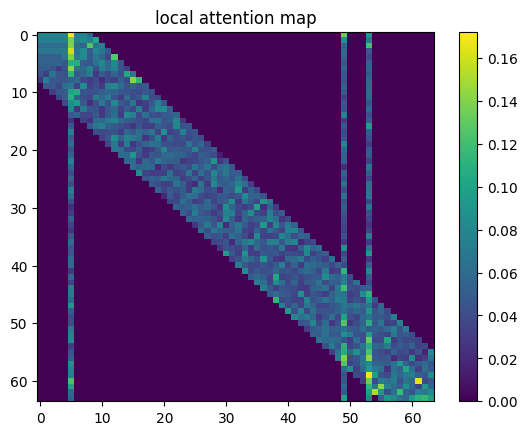

In [ ]:
plt.imshow(attn_h[0, 0].detach().cpu().numpy(), aspect='auto')
plt.colorbar()
plt.title("local attention map")
plt.show()

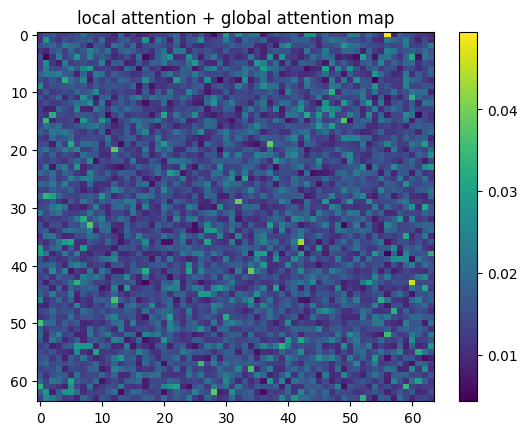

In [ ]:
# globalアテンションの実行
plt.imshow(attn_f[0, 0].detach().cpu().numpy(), aspect='auto')
plt.colorbar()
plt.title("local attention + global attention map")
plt.show()